In [1]:
from scipy.sparse.linalg import eigsh, ArpackNoConvergence
from scipy.optimize import curve_fit, OptimizeWarning
from scipy.sparse import csr_matrix, csc_matrix
from sklearn.neighbors import kneighbors_graph
from sklearn.datasets import make_swiss_roll
from scipy.sparse.csgraph import laplacian
from scipy.fftpack import fft2, ifft2
from collections import namedtuple
import matplotlib.pyplot as plt
from functools import partial
import multiprocessing
from tqdm import tqdm
import numpy as np
import warnings
import zipfile
import imageio
import pickle
import tqdm
import os
import io
from params import p
project_name = "sample"
eps = 1e-4

In [2]:
# Set the project name to before loading the parameters
p.proj_name = project_name
# When we call p.load(), it should attempt to load "params_sample.toml"
p.load()
# Print the parameters to verify they are loaded correctly
print(p)

In [3]:
class NullEmitter:
    """
    A class that provides a no-operation (no-op) implementation of an emitter.

    This class is designed to be used in contexts where an emitter is required by the interface,
    but no actual emitting action is desired. It effectively serves as a placeholder or a stub
    that satisfies the requirement of having an emitter without performing any operation.
    """
    
    def emit(self, percent):
        """
        A no-operation implementation of the emit method.

        This method is intended to fulfill the interface requirement for an emitting action
        without performing any actual work. It can be used to ignore progress updates or
        other emitting actions in a safe and controlled manner.

        Parameters:
        - percent (any): This parameter is accepted to match the expected interface of an
          emitter method, but it is not used within the method. Any value passed to this
          parameter will be ignored.

        Returns:
        None
        """
        pass

In [4]:
def debug_print(msg: str=""):
    """
    Prints a debug message along with the caller's stack trace.

    Parameters:
    - msg (str): The debug message to print. If empty, only the stack trace is printed.

    Returns:
    None
    """
    if msg:
        print(msg)
    stack = traceback.format_stack()
    print(stack[-2].split('\n')[0])

In [5]:
def fin1(filename):
    """
    Reads and returns the data from a pickle file.

    This function attempts to open a file in binary read mode and deserialize its contents using
    pickle. If an exception occurs during this process, it logs the exception message using
    `debug_print` and returns None.

    Parameters:
    - filename (str): The path to the file to be read.

    Returns:
    - The deserialized data from the file if successful, None otherwise.
    """
    with open(filename, 'rb') as f:
        try:
            data = pickle.load(f)
            return data
        except Exception as e:
            debug_print(str(e))
            return None

In [6]:
def fout1(filename, **kwargs):
    """
    Writes the given keyword arguments to a file using pickle serialization.

    This function opens a file in binary write mode and serializes the keyword arguments passed to
    it using pickle, with the highest available protocol. It ensures that the data is written
    efficiently and securely.

    Parameters:
    - filename (str): The path to the file where the data will be written.
    - **kwargs: Arbitrary keyword arguments that will be serialized and written to the file.

    Returns:
    None
    """
    with open(filename, 'wb') as f:
        pickle.dump(kwargs, f, protocol=pickle.HIGHEST_PROTOCOL)
    # Note: The file is automatically closed when exiting the 'with' block, so f.close() is not necessary.

In [7]:
# core

In [8]:
def L2_distance(a, b):
    """
    Computes the Euclidean distance matrix between two sets of vectors.

    This function calculates the pairwise Euclidean (L2) distances between vectors in two sets,
    represented by matrices A and B. The computation is vectorized for efficiency, making use
    of broadcasting and matrix operations to avoid explicit loops over elements.

    Parameters:
        a (np.ndarray): A D x M array where D is the dimensionality of each vector and M is the number
                        of vectors in the first set.
        b (np.ndarray): A D x N array where D is the dimensionality of each vector (matching the first set)
                        and N is the number of vectors in the second set.

    Returns:
        np.ndarray: An M x N array containing the Euclidean distances between each pair of vectors
                    from the first set to the second set.

    Raises:
        ValueError: If the input matrices A and B do not have the same dimensionality (i.e., the number
                    of rows D does not match).

    Note:
        - The function ensures numerical stabil ity by setting very small negative values (which can
          arise due to floating point arithmetic errors) to zero before taking the square root.
        - This implementation assumes that both input matrices are real-valued.
    """
    eps = 1e-8  # Small epsilon value for numerical stability

    # Check if input matrices have the same dimensionality
    if a.shape[0] != b.shape[0]:
        raise ValueError("A and B should be of same dimensionality")
    
    # Compute squared magnitudes of each vector in A and B
    aa = np.sum(a**2, axis=0)
    bb = np.sum(b**2, axis=0)
    
    # Compute the matrix product of A transposed and B
    ab = np.matmul(a.T, b)
    
    # Use the identity ||a - b||^2 = ||a||^2 + ||b||^2 - 2 * a^T * b to compute distance matrix
    tmp = aa[:, np.newaxis] + bb[np.newaxis, :] - 2 * ab
    
    # Ensure no negative values due to floating point errors
    tmp[tmp < eps] = 0
    
    # Return the square root of the distance matrix to get Euclidean distances
    return np.sqrt(tmp)

In [9]:
def svdRF(A):
    """
    Performs a singular value decomposition-like operation on matrix A using eigenvalue decomposition.
    
    This function is tailored for matrices that are not necessarily square, calculating the eigendecomposition
    of A^T*A or A*A^T as appropriate based on the shape of A. It then tidies up the eigenvalues and eigenvectors
    to align with the conventional output of SVD, providing matrices U, S, and V such that A ≈ U*S*V^T.

    Parameters:
        A (np.ndarray): A D1 x D2 matrix for which the SVD-like decomposition is to be performed.
                        A can be of any shape, not necessarily square.

    Returns:
        tuple: A tuple containing three elements:
               - U (np.ndarray): An orthogonal matrix containing the left singular vectors of A.
               - S (np.ndarray): A diagonal matrix with the square roots of the eigenvalues of A^T*A or A*A^T
                                 along the diagonal, representing the singular values of A.
               - V (np.ndarray): An orthogonal matrix containing the right singular vectors of A.

    Details:
        The function internally defines a `tidyUp` helper function to sort the eigenvalues and eigenvectors,
        and to calculate the matrices S (singular values) and invS (inverse of S). The choice of decomposing
        A^T*A or A*A^T is based on the dimensions of A to ensure computational efficiency.

    Note:
        This function does not directly use the SVD function from numpy.linalg but achieves a similar result
        through eigenvalue decomposition, which can be more efficient or numerically stable in certain contexts.
    """
    def tidyUp(D, EV):
        # Sort the eigenvalues and eigenvectors in descending order
        order = np.argsort(D)[::-1]
        D = np.sort(D)[::-1]
        EV = EV[:, order]
        
        # Calculate the matrices for singular values and their inverses
        sqrtD = np.sqrt(D)
        S = np.diag(sqrtD)
        invS = np.diag(1. / sqrtD)
        
        return (D, EV, S, invS)

    # Determine the shape of A and perform eigendecomposition appropriately
    D1, D2 = A.shape
    if D1 > D2:
        # For tall matrices, decompose A^T*A
        D, V = np.linalg.eigh(np.matmul(A.T, A))
        D, V, S, invS = tidyUp(D, V)
        U = np.matmul(A, np.matmul(V, invS))
    else:
        # For wide matrices, decompose A*A^T
        D, U = np.linalg.eigh(np.matmul(A, A.T))
        D, U, S, invS = tidyUp(D, U)
        V = np.matmul(A.T, np.matmul(U, invS))
    
    return (U, S, V)

In [10]:
def get_wiener(CTF, posPath, posPsi1, ConOrder, num):
    """
    Computes the Wiener filter domain for a set of CTF values.

    This function calculates the Wiener filter domain based on the given CTF values, taking into account
    the position path, the position in the Psi coordinate, the continuity order, and the total number of
    elements. It is particularly useful in cryo-EM image processing for deconvolving images with known
    CTF distortions under a specified signal-to-noise ratio (SNR).

    Parameters:
        CTF (np.ndarray): A 3D array of CTF values with shape (N, dim, dim), where N is the number of CTF
                          patterns, and 'dim' is the dimensionality of each CTF pattern.
        posPath (np.ndarray): An array of indices specifying the order in which CTF patterns are considered
                              in the analysis.
        posPsi1 (int): The position index within the Psi coordinate, indicating the specific CTF pattern
                       to start with in the computation.
        ConOrder (int): The continuity order, specifying how many adjacent CTF patterns to consider for
                        averaging in the Wiener domain calculation.
        num (int): The total number of elements or CTF patterns to include in the computation from the
                   starting position posPsi1.

    Returns:
        tuple: A tuple containing two elements:
               - wiener_dom (np.ndarray): The computed Wiener filter domain, a 3D array with shape
                                         (num - ConOrder, dim, dim), representing the filtered domain for
                                         each considered CTF pattern.
               - CTF1 (np.ndarray): The subset of CTF patterns used in the Wiener domain calculation,
                                    with shape (num - ConOrder, dim, dim).

    Notes:
        - The function assumes a constant signal-to-noise ratio (SNR) for the simplification of the Wiener
          filter calculation. The SNR is hardcoded as 5, but this value can be adjusted based on specific
          requirements or experimental data.
        - The Wiener filter domain is calculated by summing the squares of the selected CTF patterns and
          then adjusting for the SNR, following the principles of Wiener deconvolution in the frequency domain.
    """
    dim = CTF.shape[1]  # Extract the dimensionality of each CTF pattern
    SNR = 5  # Signal-to-Noise Ratio, a predefined constant for the calculation

    # Select the specific subset of CTF patterns based on posPath and posPsi1
    CTF1 = CTF[posPath[posPsi1], :, :]

    # Initialize the Wiener domain array
    wiener_dom = np.zeros((num - ConOrder, dim, dim), dtype='float64')

    # Compute the Wiener domain by summing the squared CTF patterns and adjusting for SNR
    for i in range(num - ConOrder):
        for ii in range(ConOrder):
            ind_CTF = ConOrder - ii + i
            wiener_dom[i, :, :] += CTF1[ind_CTF, :, :]**2
    wiener_dom += 1. / SNR  # Adjust for SNR

    return (wiener_dom, CTF1)

In [11]:
class _Params:
    """
    A class to hold configuration parameters for an iterative fitting or optimization process.

    This class encapsulates various parameters that control the behavior of an iterative process, such as fitting a model to data or optimizing a function. It is designed to be flexible, allowing for the easy adjustment of key parameters affecting the convergence and accuracy of the process.

    Attributes:
        nDim (int): The dimensionality of the data or parameter space. Defaults to 3.
        maxIter (int): The maximum number of iterations to perform in the optimization or fitting process. Defaults to 100.
        delta_a_max (float): The maximum allowed change in parameter 'a' between iterations, controlling convergence criteria. Defaults to 1.0.
        delta_b_max (float): The maximum allowed change in parameter 'b' between iterations, controlling convergence criteria. Defaults to 1.0.
        delta_tau_max (float): The maximum allowed change in parameter 'tau' between iterations, controlling convergence criteria. Defaults to 0.01.
        a_b_tau_result (str): The filename or path to save the result of the optimization or fitting process, specifically the optimized parameters 'a', 'b', and 'tau'. Defaults to 'a_b_tau_result.pkl'.
        p (Any): A placeholder for an additional parameter, purpose and type to be determined based on specific use case. Initially None.
        x (Any): A placeholder for the dataset or input data to which the optimization or fitting process is applied. Initially None.
        x_fit (Any): A placeholder for the fitted data or output of the optimization process. Initially None.

    Note:
        - The class is designed with flexibility in mind, allowing for the addition or modification of parameters as needed for specific applications.
        - The exact nature and use of the `p`, `x`, and `x_fit` attributes are intentionally left undefined to accommodate a wide range of possible use cases.
    """
    def __init__(self):
        self.nDim: int = 3
        self.maxIter: int = 100
        self.delta_a_max: float = 1.
        self.delta_b_max: float = 1.
        self.delta_tau_max: float = 0.01
        self.a_b_tau_result: str = 'a_b_tau_result.pkl'
        self.p = None
        self.x = None
        self.x_fit = None

In [12]:
def _R_p(tau_p, a):
    """
    Calculates the residual value(s) for a given tau parameter and a set of model parameters.

    This function computes the sum of squared errors (SSE) between the model predictions and actual data,
    given a specific value of the tau parameter. The model appears to involve a trigonometric relationship
    between input data and parameters, highlighting its potential use in periodic or oscillatory systems.

    Parameters:
        tau_p (float or np.ndarray): The tau parameter value(s) at which the residuals are to be calculated.
                                     This can be a single value or an array of values.
        a (_Params): An instance of the _Params class containing the configuration and parameters for the
                     model fitting process. It must have the following attributes defined:
                     - nDim: The dimensionality of the data or parameter space.
                     - a: The scaling factor(s) applied to the cosine component of the model.
                     - b: The offset or bias term in the model.
                     - x: The dataset or input data to which the model is being fitted.
                     - p: The index or indices of the data points being considered in the calculation.

    Returns:
        np.ndarray: An array of residual value(s) corresponding to the input tau parameter value(s).
                    Each element in the array represents the SSE for a given value of tau_p.

    Note:
        - The function assumes that the input data `x`, model parameters `a` and `b`, and the index `p`
          are all attributes of the `a` (_Params) instance. This design implies that the function is
          closely tied to the specific structure and use case of the _Params class.
        - The calculation involves a cosine function, suggesting that the model may be used to fit
          data exhibiting periodic or oscillatory behavior.
    """
    # Create an array of integers from 1 to nDim inclusive, representing dimensions or components
    jj = np.array(range(1, a.nDim + 1))
    
    # Calculate the cosine argument based on tau_p and dimension indices
    j_pi_tau_p = tau_p * jj * np.pi
    
    # Apply the model (a cosine function scaled by 'a.a' and offset by 'a.b') to calculate predictions
    a_cos_j_pi_tau_p = a.a * np.cos(j_pi_tau_p)
    
    # Compute the error between model predictions and actual data for the specified data point(s)
    err = a.x[a.p, :] - a.b - a_cos_j_pi_tau_p
    
    # Calculate and return the sum of squared errors
    fval = np.sum(err**2, axis=1)
    return fval

In [13]:
def _solve_d_R_d_tau_p_3D(a: _Params):
    '''
    Solves for the tau value that minimizes the residual in a 3D model fitting process.

    This function calculates the tau parameter for a data point 'p' that minimizes the residual
    of a model defined by the equation x_ij = a_j * cos(j*pi*tau_i) + b_j, where 'j' ranges from 1 to 3,
    making it specifically designed for 3D systems.

    The process involves solving the derivative of the residual with respect to tau, setting it to zero,
    and finding the roots of the resulting polynomial equation.

    Parameters:
        a (_Params): An instance of the _Params class containing all the necessary parameters
                     and configurations for the model fitting process. It includes:
                     - a: Coefficients for the model as a 1 x 3 array.
                     - b: Offset terms for the model as a 1 x 3 array.
                     - x: Data points to be fitted as an nS x 3 array.
                     - p: Index of the data point of interest within 'x'.

    Returns:
        tuple: A tuple containing:
               - tau (float): The value of tau for the data point 'p' that minimizes the residual.
               - beta (np.ndarray): The roots found from the derivative of the residual with respect
                                    to tau, including both physical and non-physical solutions.

    Note:
        The function identifies candidate tau values by solving for the roots of the derivative of
        the residual and applies physical constraints to select valid solutions. Non-real or out-of-bound
        roots are discarded, ensuring the chosen tau is physically meaningful.
    '''
    # Construct polynomial coefficients for the derivative of the residual
    d_R_d_beta_3D = np.array([
        48 * a.a[2]**2, 0, 8 * a.a[1]**2 - 48 * a.a[2]**2, -12 * a.a[2] * (a.x[a.p, 2] - a.b[2]),
        a.a[0]**2 - 4 * a.a[1]**2 + 9 * a.a[2]**2 - 4 * a.a[1] * (a.x[a.p, 1] - a.b[1]),
        -a.a[0] * (a.x[a.p, 0] - a.b[0]) + 3 * a.a[2] * (a.x[a.p, 2] - a.b[2])
    ]).T

    # Solve the polynomial equation to find roots
    beta = np.roots(d_R_d_beta_3D)

    # Filter out roots with non-zero imaginary parts
    tmp = np.absolute(np.imag(beta)) > 0
    tmp = np.nonzero(tmp)[0]
    beta1 = np.delete(beta, tmp, None)

    # Further filter roots with absolute values greater than 1
    tmp = np.absolute(beta1) > 1
    tmp = np.nonzero(tmp)[0]
    beta = np.real(np.delete(beta1, tmp, None))

    # Convert valid roots to candidate tau values
    tau_candidate = np.vstack((np.arccos(beta.reshape(-1, 1)) / np.pi, 0, 1))

    # Select the tau value that minimizes the residual
    id = np.argmin(_R_p(tau_candidate, a))
    tau = tau_candidate[id]

    return tau, beta

In [14]:
def _get_fit_params(psi):
    """
    Computes initial fitting parameters for a given input matrix 'psi', involving complex
    mathematical operations to estimate parameters for a 3D model fitting process.

    This function calculates initial guesses for parameters {a, b, tau} based on the input 'psi'.
    It utilizes polynomial fitting to estimate these parameters, specifically focusing on 
    the fitting of data in 2D for {a, b} and setting derivatives to zero for {tau}. 
    The process includes solving a series of linear equations and polynomial expressions to 
    find these initial parameter guesses.

    Parameters:
        psi (np.ndarray): A 2D numpy array containing the data points for which the initial
                          fitting parameters are to be calculated.

    Returns:
        tuple: A tuple containing two elements:
               - np.ndarray: An array of tau values, representing one of the fitting parameters.
               - _Params: An instance of the _Params class populated with the initial fitting parameters,
                          including maximum iterations, delta values, result paths, and the calculated
                          values of a, b, and tau.

    Raises:
        ValueError: If certain calculations result in invalid values that cannot be used for further
                    computation, such as a negative discriminant during square root operations.

    Note:
        This function assumes 'psi' is structured with specific columns representing different 
        dimensions of the data. It is part of a larger fitting process, where these initial parameters
        are refined through iterative optimization methods.
    """
    a = _Params()
    a.maxIter = 100  # maximum number of iterations, each iteration determines optimum sets of {a,b} and {\tau} in turns
    a.delta_a_max = 1  # maximum percentage change in amplitudes
    a.delta_b_max = 1  # maximum percentage change in offsets
    a.delta_tau_max = 0.01  # maximum change in values of tau
    a.a_b_tau_result = 'a_b_tau_result.pkl'  # save final results here
    nS = psi.shape[0]
    a.x = psi[:, 0:3]
    # initial guesses for {a,b} obtained by fitting data in 2D
    # initial guesses for {tau} obtained by setting d(R)/d(tau) to zero
    X = psi[:, 0]
    Z = psi[:, 2]
    X2 = X * X
    X3 = X2 * X
    X4 = X2 * X2
    X5 = X3 * X2
    X6 = X3 * X3
    sumX = np.sum(X)
    sumX2 = np.sum(X2)
    sumX3 = np.sum(X3)
    sumX4 = np.sum(X4)
    sumX5 = np.sum(X5)
    sumX6 = np.sum(X6)
    sumZ = np.sum(Z)
    sumXZ = np.dot(X.T, Z)
    sumX2Z = np.dot(X2.T, Z)
    sumX3Z = np.dot(X3.T, Z)
    A = np.array([[sumX6, sumX5, sumX4, sumX3], [sumX5, sumX4, sumX3, sumX2], [sumX4, sumX3, sumX2, sumX],
                  [sumX3, sumX2, sumX, nS]])
    b = np.array([sumX3Z, sumX2Z, sumXZ, sumZ])
    coeff = np.linalg.lstsq(A, b, rcond=None)[0]
    D = coeff[0]
    E = coeff[1]
    F = coeff[2]
    G = coeff[3]
    disc = E * E - 3 * D * F
    if disc < 0:
        disc = 0.
    if np.absolute(D) < 1e-8:
        D = 1e-8
    a1 = (2. * np.sqrt(disc)) / (3. * D)
    a3 = (2. * disc**(3 / 2.)) / (27. * D * D)
    b1 = -E / (3 * D)
    b3 = (2. * E * E * E) / (27. * D * D) - (E * F) / (3 * D) + G
    Xb = X - 2 * b1
    Y = psi[:, 1]
    XXb = X * Xb
    X2Xb2 = XXb * XXb
    sumXXb = np.sum(XXb)
    sumX2Xb2 = np.sum(X2Xb2)
    sumY = np.sum(Y)
    sumXXbY = np.dot(XXb.T, Y)
    A = np.array([[sumX2Xb2, sumXXb], [sumXXb, nS]])
    b = np.array([sumXXbY, sumY])
    coeff = np.linalg.lstsq(A, b, rcond=None)[0]
    A = coeff[0]
    C = coeff[1]
    a2 = 2. * A * disc / (9. * D * D)
    b2 = C + (A * E * E) / (9. * D * D) - (2. * A * F) / (3. * D)
    a.a = np.array([a1, a2, a3])
    a.b = np.array([b1, b2, b3])
    tau = np.zeros((nS, 1))
    for a.p in range(nS):
        tau[a.p], _ = _solve_d_R_d_tau_p_3D(a)
    return tau, a

In [15]:
def fit_1D_open_manifold_3D(psi):
    """
    Fits the eigenvectors for a 1D open manifold to a 3D model using the equation:
    x_ij = a_j cos(j*pi*tau_i) + b_j, where 'j' ranges from 1 to 3 for 3D systems, and 'i' ranges from 1 to 'nS',
    the number of data points to be fitted. This fitting process involves iterative optimization to find the 
    parameters 'a_j', 'b_j', and 'tau_i' that best fit the input data 'psi'.

    Parameters:
        psi (np.ndarray): A 2D numpy array containing the data points for the fitting process.

    Returns:
        tuple: A tuple containing three elements:
               - np.ndarray: The optimized 'a' coefficients for the model.
               - np.ndarray: The optimized 'b' coefficients for the model.
               - np.ndarray: The optimized 'tau' values for each data point in the model.

    Note:
        - This function implements an iterative fitting procedure where for a fixed set of 'a_j' and 'b_j', 'tau_i'
          are obtained by zeroing the derivative of 'R' with respect to 'tau_i'. Conversely, for a fixed set of 'tau_i',
          'a_j' and 'b_j' are optimized by solving sets of linear equations.
        - The fitting parameters and the initial set of 'tau' are specified in 'get_fit_1D_open_manifold_3D_param.m'.
        - This implementation is adapted from the work of Russell Fung (2014) and translated into Python by
          Columbia University Hstau Liao (2018).

    Raises:
        ValueError: If the fitting process encounters numerical issues or fails to converge within the specified
                    number of iterations.
    """
    tau, a = _get_fit_params(psi)
    aux = np.zeros((tau.shape[0], 5))
    nS = a.x.shape[0]
    for iter in range(1, a.maxIter + 1):
        # solve for a and b
        a_old = a.a
        b_old = a.b
        j_pi_tau = np.dot(tau, np.pi * np.array([[1, 2, 3]]))
        cos_j_pi_tau = np.cos(j_pi_tau)
        A11 = np.sum(cos_j_pi_tau**2, axis=0)
        A12 = np.sum(cos_j_pi_tau, axis=0)
        A21 = A12
        A22 = nS
        x_cos_j_pi_tau = a.x * cos_j_pi_tau
        b1 = np.sum(x_cos_j_pi_tau, axis=0)
        b2 = np.sum(a.x, axis=0)
        coeff = np.zeros((2, 3))
        for qq in range(3):
            A = np.array([[A11[qq], A12[qq]], [A21[qq], A22]])
            b = np.array([b1[qq], b2[qq]])
            coeff[:, qq] = np.linalg.lstsq(A, b, rcond=None)[0]

        a.a = coeff[0, :]
        a.b = coeff[1, :]
        # plot the fitted curve (plotting functionality omitted for brevity)
        j_pi_tau = np.dot(np.linspace(0, 1, 1000).reshape(-1, 1), np.array([[1, 2, 3]])) * np.pi
        cos_j_pi_tau = np.cos(j_pi_tau)
        tmp = a.a * cos_j_pi_tau
        a.x_fit = tmp + a.b
        # solve for tau
        tau_old = tau
        for a.p in range(nS):
            tau[a.p], beta = _solve_d_R_d_tau_p_3D(a)
            for kk in range(beta.shape[0]):
                aux[a.p, kk] = beta[kk]
        # calculate the changes in fitting parameters
        delta_a = np.fabs(a.a - a_old) / (np.fabs(a.a) + eps)
        delta_b = np.fabs(a.b - b_old) / (np.fabs(a.b) + eps)
        delta_tau = np.fabs(tau - tau_old)
        delta_a = max(delta_a) * 100
        delta_b = max(delta_b) * 100
        delta_tau = max(delta_tau)

        if (delta_a < a.delta_a_max) and (delta_b < a.delta_b_max) and (delta_tau < a.delta_tau_max):
            break
    return (a.a, a.b, tau)

In [16]:
def fergusonE(D, logEps, a0=None):
    """
    Fits a curve using a hyperbolic tangent function to the data provided and returns the optimized parameters.

    This function attempts to fit a curve defined by a hyperbolic tangent function to the given data points.
    It uses the scipy.optimize.curve_fit method for curve fitting. The function also calculates the threshold
    for weighting the data points based on the provided logarithmic epsilon values and distances.

    Parameters:
    - D (np.ndarray): An array of distances between data points.
    - logEps (np.ndarray): An array of logarithmic epsilon values to be used for curve fitting.
    - a0 (np.ndarray, optional): Initial guess for the parameters of the hyperbolic tangent function.
      If None, a default value of ones(4) is used.

    Returns:
    - tuple: A tuple containing the following elements:
        - popt (np.ndarray): Optimal values for the parameters so that the sum of the squared residuals
          of fun(xdata, *popt) - ydata is minimized.
        - logSumWij (np.ndarray): Logarithm of the sum of weighted distances for each logEps value.
        - resnorm (float): The sum of the square roots of the absolute values of the diagonal of the
          covariance matrix of the parameters.
        - R_squared (float): Coefficient of determination, indicating the proportion of the variance in
          the dependent variable that is predictable from the independent variable(s).

    Notes:
    - The function internally defines a `fun` function representing a hyperbolic tangent model and a
      `find_thres` function to calculate a threshold for weighting the data points.
    - The curve fitting process iterates until the residual norm (resnorm) is less than 100, adjusting
      the initial guess for the parameters (a0) in each iteration if necessary.
    - This function uses scipy's curve_fit method, which may not converge to a solution; in such cases,
      it prints the residual norm, the parameters attempted, and the error identifier (ier).
    """
    if a0 is None:
        a0 = np.ones(4)
    def fun(x, a, b, c, d):
        return d + c * np.tanh(a * x + b)
    def find_thres(logEps, D2):
        d = 0.5 * D2 / np.exp(np.max(logEps))
        ss = np.sum(np.exp(-d))
        return max(-np.log(0.01 * ss / len(D2)), 10)  # Taking 1% of the average (10)
    # Range of values to try:
    logSumWij = np.empty_like(logEps)
    D2 = D * D
    thr = find_thres(logEps, D2)
    for k, le in enumerate(logEps):
        d = 0.5 * D2 / np.exp(le)
        Wij = np.exp(-d[d < thr])  # See Coifman 2008
        logSumWij[k] = np.log(np.sum(Wij))
    # Curve fitting of a tanh():
    resnorm = np.inf
    while (resnorm > 100):
        popt, pcov, infodict, mesg, ier = curve_fit(fun, logEps, logSumWij, p0=a0, full_output=True)
        resnorm = np.sum(np.sqrt(np.fabs(np.diag(pcov))))
        if ier < 1 or ier > 4:
            print(resnorm, popt, ier)
        a0 *= 0.5
        residuals = logSumWij - fun(logEps, *popt)
        ss_res = np.sum(residuals**2)  # Residual sum of squares
        ss_tot = np.sum((logSumWij - np.mean(logSumWij))**2)  # Total sum of squares
        R_squared = 1 - (ss_res / ss_tot)  # R**2 value
    return (popt, logSumWij, resnorm, R_squared)

In [17]:
# DMembeddingII

In [18]:
def slaplacian(*arg):
    """
    Given a set of nS data points, and the distances to nN nearest neighbors
    for each data point, slaplacian computes a sparse, nY by nY symmetric
    graph Laplacian matrix l.

    The input data are supplied in the column vectors yVal and yInd of length
    nY * nN such that

    yVal( ( i - 1 ) * nN + ( 1 : nN ) ) contains the distances to the
    nN nearest neighbors of data point i sorted in ascending order, and

    yInd( ( i - 1 ) * nN + ( 1 : nN ) ) contains the indices of the nearest
    neighbors.

    yVal and yInd can be computed by calling nndist

    slaplacian admits a number of options passed as name-value pairs

    alpha : normalization, according to Coifman & Lafon

    nAutotune : number of nearest neighbors for autotuning. Set to zero if no
    autotuning is to be performed

    sigma: width of the Gaussian kernel
    """
    yVal = arg[0]
    yCol = arg[1]
    yRow = arg[2]
    nS = arg[3]  # dataset size
    options = arg[4]  # options.sigma: Gaussian width
    nNZ = len(yVal)  # Number of nonzero elements

    # If required, compute autotuning distances:
    if options.autotune > 0:
        print('Autotuning is not implemented in this version of slaplacian' + '\n')
    else:
        sigmaTune = options.sigma

    yVal = yVal / sigmaTune**2
    # Compute the unnormalized weight matrix:
    yVal = np.exp(-yVal)  # apply exponential weights (yVal is distance**2)
    l = csc_matrix((yVal, (yRow, yCol)), shape=(nS, nS))
    d = np.array(l.sum(axis=0)).T

    if options.alpha != 1:  # apply non-isotropic normalization
        d = d**options.alpha

    yVal = yVal / (d[yRow].flatten('C') * d[yCol].flatten('C'))
    l = csc_matrix((yVal, (yRow, yCol)), shape=(nS, nS))

    # Normalize by the degree matrix to form normalized graph Laplacian:
    d = np.array(l.sum(axis=0))
    d = np.sqrt(d).T
    yVal = yVal / (d[yRow].flatten('C') * d[yCol].flatten('C'))
    l = csc_matrix((yVal, (yRow, yCol)), shape=(nS, nS))
    l = np.abs(l + l.T) / 2.0  # iron out numerical wrinkles
    temp = l - l.T

    return (l, sigmaTune)

In [19]:
def sembedding(yVal, yCol, yRow, nS, options1):
    """
    Laplacian eigenfunction embedding using sparse arrays.

    This function computes the eigenvalues and eigenvectors of the Laplacian matrix of a graph,
    which represents the dataset. The Laplacian matrix is constructed based on the input sparse
    matrix components (values, column indices, row pointers) and options specifying the embedding
    parameters.

    Parameters:
    - yVal (np.ndarray): The values of the non-zero elements in the sparse matrix representation.
    - yCol (np.ndarray): The column indices of the non-zero elements in the sparse matrix.
    - yRow (np.ndarray): The row indices of the non-zero elements in the sparse matrix.
    - nS (int): The number of samples or nodes in the graph.
    - options1 (namedtuple): A namedtuple containing the options for the embedding. Expected fields
      are sigma (float), alpha (float), visual (bool), nEigs (int), and autotune (int).

    Returns:
    - tuple: A tuple containing the following elements:
        - vals (np.ndarray): The computed eigenvalues of the Laplacian matrix.
        - vecs (np.ndarray): The computed eigenvectors of the Laplacian matrix, corresponding to the eigenvalues.

    Notes:
    - The function attempts to compute the specified number of eigenvalues and eigenvectors using
      the ARPACK solver via scipy.sparse.linalg.eigsh. If the solver does not converge within the
      specified maximum number of iterations, it catches the ArpackNoConvergence exception and
      returns the eigenvalues and eigenvectors that were computed up to that point.
    """
    # Create a new options namedtuple with values from options1
    options = namedtuple('options', 'sigma alpha visual nEigs autotune')
    options.sigma = options1.sigma
    options.alpha = options1.alpha
    options.nEigs = options1.nEigs
    options.autotune = 0  # Autotuning is disabled in this implementation

    # Compute the sparse Laplacian matrix
    l, sigmaTune = slaplacian(yVal, yCol, yRow, nS, options)

    # Attempt to compute the eigenvalues and eigenvectors of the Laplacian matrix
    try:
        vals, vecs = eigsh(l, k=options.nEigs + 1, maxiter=300, v0=np.ones(nS), return_eigenvectors=True)
    except ArpackNoConvergence as e:
        # Handle the case where ARPACK does not converge within the maximum number of iterations
        vals = e.eigenvalues
        vecs = e.eigenvectors
        print("eigsh not converging in 300 iterations...")

    # Sort the eigenvalues and eigenvectors in descending order
    ix = np.argsort(vals)[::-1]
    vals = vals[ix]
    vecs = vecs[:, ix]

    return (vals, vecs)

In [20]:
def get_yColVal(params):
    """
    Processes and updates arrays for values and column indices in a sparse matrix representation.

    This function takes a set of parameters related to the sparse matrix construction, including
    arrays of values and indices, and updates these arrays based on the provided batch of data.
    It is typically used in the context of constructing or updating a sparse representation of a
    graph or matrix, especially when dealing with large datasets that require batching.

    Parameters:
    - params (tuple): A tuple containing the following elements:
        - yVal (np.ndarray): The values of the non-zero elements in the sparse matrix.
        - yVal1 (np.ndarray): The original values from which yVal will be updated.
        - yCol (np.ndarray): The column indices of the non-zero elements in the sparse matrix.
        - yInd1 (np.ndarray): The original indices from which yCol will be updated.
        - nB (int): The batch size, indicating the number of data points processed in this batch.
        - nN (int): The number of nearest neighbors considered for each data point.
        - nNIn (int): The initial number of nearest neighbors before filtering.
        - jStart (int): The start index of the current batch.
        - jEnd (int): The end index of the current batch.
        - indStart (int): The start index for updating yVal and yCol.
        - indEnd (int): The end index for updating yVal and yCol.
        - iBatch (int): The current batch number.

    Returns:
    - tuple: A tuple containing the updated yCol and yVal arrays.

    Notes:
    - The function reshapes and filters the input arrays yVal1 and yInd1 based on the batch
      information and the number of nearest neighbors. It then updates the yVal and yCol arrays
      with the processed data for the current batch.
    - This function is part of a larger process of constructing or updating sparse matrices and
      is designed to handle data in batches for efficiency and scalability.
    """
    yVal = params[0]
    yVal1 = params[1]
    yCol = params[2]
    yInd1 = params[3]
    nB = params[4]
    nN = params[5]
    nNIn = params[6]
    jStart = params[7]
    jEnd = params[8]
    indStart = params[9]
    indEnd = params[10]
    iBatch = params[11]

    # Reshape and filter the data batch for values
    DataBatch = yVal1
    DataBatch = DataBatch.reshape(nB, nNIn).T
    DataBatch = DataBatch[:nN, :]
    DataBatch[0, :] = 0  # Reset the first row to zeros
    yVal[indStart:indEnd] = DataBatch.reshape(nN * nB, 1)

    # Reshape and filter the data batch for column indices
    DataBatch = yInd1
    DataBatch = DataBatch.reshape(nB, nNIn).T
    DataBatch = DataBatch[:nN, :]
    yCol[indStart:indEnd] = DataBatch.reshape(nN * nB, 1).astype(float)

    return (yCol, yVal)

In [21]:
def initialize(nS, nN, D):
    """
    Initializes the arrays of indices and values for constructing a sparse matrix
    representation of distances between data points.

    This function processes a distance matrix to identify the nearest neighbors for each
    data point. It then creates arrays that store the indices of these neighbors and the
    corresponding distance values. The first distance value for each data point is set to
    zero to indicate self-distance, ensuring the diagonal of the distance matrix is zero.

    Parameters:
    - nS (int): The number of samples or data points.
    - nN (int): The number of nearest neighbors to consider for each data point.
    - D (np.ndarray): A square distance matrix of shape (nS, nS) where D[i, j] represents
      the distance between the i-th and j-th data points.

    Returns:
    - tuple: A tuple containing two flattened arrays:
        - yInd1 (np.ndarray): A flattened array of indices of the nearest neighbors for each data point.
        - yVal1 (np.ndarray): A flattened array of the corresponding distance values to the nearest neighbors.

    Notes:
    - The function modifies the input distance matrix D by setting the diagonal elements to
      negative infinity to ensure that each data point's self-distance does not affect the
      nearest neighbors' calculation.
    - After identifying the nearest neighbors and their distances, the function resets the
      first distance value for each data point to zero, effectively ignoring self-distance
      in the sparse matrix representation.
    """
    yInd1 = np.zeros((nN, nS), dtype='int32')
    yVal1 = np.zeros((nN, nS), dtype='float64')
    
    for iS in range(nS):
        D[iS, iS] = -np.Inf  # Force this distance to be the minimal value
        B = np.sort(D[:, iS])
        IX = np.argsort(D[:, iS])
        yInd1[:, iS] = IX[:nN]
        yVal1[:, iS] = B[:nN]
        yVal1[0, iS] = 0  # Set this distance back to zero
    
    yInd1 = yInd1.flatten('F')
    yVal1 = yVal1.flatten('F')
    
    return (yInd1, yVal1)

In [22]:
def construct_matrix0(Row, Col, Val, nZ, nS):
    """
    Constructs a symmetric matrix from given row indices, column indices, and values,
    specifically designed for handling squared distances.

    This function first creates a sparse matrix from the given row indices, column indices,
    and values. It then converts this sparse matrix to a dense array and performs operations
    to ensure that the resulting matrix is symmetric and represents squared distances
    correctly.

    Parameters:
    - Row (np.ndarray): An array of row indices for the non-zero elements in the matrix.
    - Col (np.ndarray): An array of column indices for the non-zero elements in the matrix.
    - Val (np.ndarray): An array of values corresponding to the non-zero elements in the matrix.
    - nZ (int): The number of zero elements in the matrix. This parameter is accepted but not
      directly used in the function, indicating potential use in extended functionality or
      error checking.
    - nS (int): The size of the square matrix to be constructed, indicating both the number
      of rows and columns.

    Returns:
    - np.ndarray: A symmetric matrix constructed from the input parameters, with adjustments
      to ensure correct representation of squared distances.

    Notes:
    - The function first constructs a sparse CSR (Compressed Sparse Row) matrix from the input
      indices and values. It then converts this sparse matrix to a dense array.
    - It computes the square of the dense array and its transpose to handle squared distances.
    - The final matrix is adjusted by adding the original matrix and its transpose, then
      subtracting a matrix that contains the squares of the distances, to ensure symmetry
      and correct distance representation.
    """
    # Create a sparse CSR matrix from the given indices and values
    y = csr_matrix((Val, (Row, Col)), shape=(nS, nS)).toarray()
    
    # Compute the square of the dense array and its transpose
    y2 = y * y.T  # y2 contains the squares of the distances
    
    # Square the original matrix
    y = y**2
    
    # Adjust the matrix to ensure symmetry and correct representation of squared distances
    y = y + y.T - y2
    
    return y

In [23]:
def construct_matrix1(Row, Col, Val, nZ, nS):
    """
    Constructs a symmetric matrix from given row indices, column indices, and values.
    This version simplifies the process by directly adjusting for symmetry without explicitly
    squaring the matrix values.

    Parameters:
    - Row (np.ndarray): An array of row indices for the non-zero elements in the matrix.
    - Col (np.ndarray): An array of column indices for the non-zero elements in the matrix.
    - Val (np.ndarray): An array of values corresponding to the non-zero elements in the matrix.
    - nZ (int): The number of zero elements in the matrix. This parameter is accepted but not
      directly used in the function, indicating potential use in extended functionality or
      error checking.
    - nS (int): The size of the square matrix to be constructed, indicating both the number
      of rows and columns.

    Returns:
    - np.ndarray: A symmetric matrix constructed from the input parameters. The symmetry is
      achieved by adding the matrix to its transpose and then subtracting the element-wise
      product of the matrix and its transpose.

    Notes:
    - The function constructs a sparse CSR (Compressed Sparse Row) matrix from the input indices
      and values and then converts this sparse matrix to a dense array.
    - It ensures the symmetry of the resulting matrix by adding it to its transpose and
      subtracting the element-wise product of the matrix and its transpose, which contains
      the squares of the original distances. This operation corrects for any asymmetries
      that might arise from the input data or the sparse matrix construction process.
    """
    # Create a sparse CSR matrix from the given indices and values
    y = csr_matrix((Val, (Row, Col)), shape=(nS, nS)).toarray()
    
    # Compute the element-wise product of the matrix and its transpose
    y2 = y * y.T  # y2 contains the squares of the distances
    
    # Adjust the matrix to ensure symmetry
    y = y + y.T - y2
    
    return y

In [24]:
def DMembeddingIIop(D, k, tune, prefsigma):
    """
    Performs spectral embedding of data points based on their pairwise distances using
    the diffusion maps approach. This function initializes the necessary structures,
    processes the data to construct a symmetric distance matrix, and performs spectral
    decomposition to obtain embedding coordinates. Additionally, it estimates the optimal
    sigma for the Gaussian kernel using the Ferguson method.

    Parameters:
    - D (np.ndarray): A square matrix of pairwise distances between data points.
    - k (int): The number of nearest neighbors to consider.
    - tune (float): A tuning parameter for adjusting the Gaussian kernel width.
    - prefsigma (float): A predefined sigma value for the Gaussian kernel, used if the
      tuning process based on the Ferguson method does not converge.

    Returns:
    - tuple: A tuple containing the following elements:
        - lamb (np.ndarray): The computed eigenvalues of the Laplacian matrix.
        - psi (np.ndarray): The computed eigenvectors of the Laplacian matrix, representing
          the embedding coordinates.
        - sigma (float): The final sigma value used for the Gaussian kernel.
        - mu (np.ndarray): The Riemannian measure derived from the first eigenvector.
        - logEps (np.ndarray): The logarithmic epsilon values used in the Ferguson method.
        - logSumWij (np.ndarray): The logarithm of the sum of weights for each logEps value.
        - popt (np.ndarray): The optimized parameters from the Ferguson curve fitting.
        - R_squared (float): The coefficient of determination from the curve fitting.

    Notes:
    - The function begins by initializing nearest neighbors and constructing a symmetric
      distance matrix through batch processing.
    - It employs the Ferguson method to estimate the optimal sigma for the Gaussian kernel
      based on the distance matrix.
    - Spectral decomposition of the Laplacian matrix is performed to obtain the embedding
      coordinates (psi) and the eigenvalues (lamb).
    - The process includes a fallback to a predefined sigma (prefsigma) if the tuning does
      not converge within a specified threshold.
    - The Riemannian measure (mu) is calculated as the square of the first eigenvector,
      normalized so that its sum equals 1. This measure can be used to weight the embedded
      points in further analysis.
    """
    nS = D.shape[0]
    nN = k  # Total number of entries is nS*nN
    yInd1, yVal1 = initialize(nS, nN, D)

    # Diffraction patterns:
    nB = nS  # Batch size (number of diff. patterns per batch)
    nNIn = k  # Number of input nearest neighbors
    nN = k  # Number of output nearest neighbors
    yVal = np.zeros((nS * nN, 1))
    yCol = np.zeros((nS * nN, 1))
    nBatch = int(nS / nB)

    for iBatch in range(nBatch):
        # Linear indices in the non-symmetric distance matrix (indStart, indEnd)
        indStart = iBatch * nB * nN
        indEnd = (iBatch + 1) * nB * nN
        # Diffraction pattern indices (jStart, jEnd):
        jStart = iBatch * nB
        jEnd = (iBatch + 1) * nB
        params = (yVal, yVal1, yCol, yInd1, nB, nN, nNIn, jStart, jEnd, indStart, indEnd, iBatch)
        yCol, yVal = get_yColVal(params)

    # Symmetrizing the distance matrix
    yRow = np.ones((nN, 1)) * range(nS)
    yRow = yRow.reshape(nS * nN, 1)
    ifZero = yVal < 1e-6
    yRowNZ = yRow[~ifZero]
    yColNZ = yCol[~ifZero]
    yValNZ = np.sqrt(yVal[~ifZero])
    nNZ = len(yRowNZ)  # Number of nonzero elements in the non-sym matrix
    yRow = yRow[ifZero]
    yCol = yCol[ifZero]
    nZ = len(yRow)  # Number of zero elements in the non-sym matrix
    y = construct_matrix0(yRowNZ, yColNZ, yValNZ, nZ, nS)
    yRowNZ = y.nonzero()[0]
    yColNZ = y.nonzero()[1]
    yValNZ = y[y.nonzero()]
    nNZ = len(y.nonzero()[0]) # Number of nonzero elements in the sym matrix
    y = construct_matrix1(yRow, yCol, np.ones((nZ, 1)).flatten(), nZ, nS)
    y = csr_matrix((np.ones((nZ, 1)).flatten(), (yRow, yCol)), shape=(nS, nS)).toarray()
    yRow = y.nonzero()[0]
    yCol = y.nonzero()[1]
    yVal = y[y.nonzero()]
    yVal[:] = 0
    nZ = len(y.nonzero()[0])  #number of zero elements in the sym matrix
    yRow = np.hstack((yRow, yRowNZ)).astype(int)
    yCol = np.hstack((yCol, yColNZ)).astype(int)
    yVal = np.hstack((yVal, yValNZ))
    count = 0
    resnorm = np.inf
    logEps = np.arange(-150, 150.2, 0.2)
    popt, logSumWij, resnorm, R_squared = fergusonE(np.sqrt(yVal), logEps)
    nS = D.shape[0]
    nEigs = min(p.num_eigs, nS - 3)  # Number of eigenfunctions to compute
    nA = 0  # Autotuning parameter
    nN = k  # Number of nearest neighbors
    nNA = 0  # Number of nearest neighbors used for autotuning
    if count < 20:
        alpha = 1  # Kernel normalization
        sigma = tune * np.sqrt(2 * np.exp(-popt[1] / popt[0]))  # Gaussian Kernel width (=1 for autotuning)
    else:
        print('using prefsigma...')  # Fallback to predefined sigma
        sigma = prefsigma
        alpha = 1
    visual = 1
    options = namedtuple('Options', 'sigma alpha visual nEigs')
    options.sigma = sigma
    options.alpha = alpha
    options.visual = visual
    options.nEigs = nEigs
    lamb, v = sembedding(yVal, yCol, yRow, nS, options)
    true_shape = v.shape[1] - 1
    psi = np.zeros((v.shape[0], nEigs))
    psi[:, :true_shape] = v[:, 1:] / np.tile(v[:, 0].reshape((-1, 1)), (1, true_shape))
    mu = v[:, 0]
    mu = mu * mu  # The Riemannian measure
    return (lamb, psi, sigma, mu, logEps, logSumWij, popt, R_squared)

In [25]:
def _corr(a, b, n, m):
    """
    Calculates the correlation coefficient between two vectors extracted from matrices 'a' and 'b'.

    The function selects vectors from the n-th column of matrix 'a' and the m-th column of matrix 'b',
    normalizes these vectors by subtracting their means, and computes the correlation coefficient
    between the normalized vectors.

    Parameters:
        a (np.ndarray): A 2D numpy array from which the first vector is selected.
        b (np.ndarray): A 2D numpy array from which the second vector is selected.
        n (int): The column index in 'a' from which the vector is selected.
        m (int): The column index in 'b' from which the vector is selected.

    Returns:
        float: The correlation coefficient between the two selected vectors.

    Raises:
        RuntimeError: If the computation encounters a "flat image" scenario where the standard
        deviation of the vectors becomes zero, leading to a division by zero in the correlation
        calculation.

    Note:
        This function is sensitive to "flat" vectors where there's no variation in the data, as
        indicated by the zero standard deviation check that could raise a RuntimeError.
    """
    A = a[:, n]
    B = b[:, m]
    A = A - np.mean(A)
    B = B - np.mean(B)
    try:
        co = np.dot(A, B) / (np.std(A) * np.std(B))
    except RuntimeError:
        raise RuntimeError("flat image")
    return co

In [26]:
def _diff_corr(a, b, maxval):
    """
    Computes a differential correlation metric between two matrices 'a' and 'b'.

    This metric is derived by calculating the correlation between corresponding vectors in 'a'
    and 'b' at indices 0 and 'maxval', then finding the difference between these correlations
    and the cross correlations at indices (0, maxval) and (maxval, 0). This method can highlight
    differences in correlation patterns across the matrices, useful in comparative analysis.

    Parameters:
        a (np.ndarray): The first 2D numpy array for correlation calculation.
        b (np.ndarray): The second 2D numpy array for correlation calculation.
        maxval (int): The maximum column index used for calculating differential correlation.

    Returns:
        float: The differential correlation metric calculated across the specified indices
        of matrices 'a' and 'b'.

    Example:
        If 'a' and 'b' represent matrices with temporal data across different conditions, this
        metric can indicate changes in correlation structure between these conditions at
        specific points in time or space.
    """
    return _corr(a, b, 0, 0) + _corr(a, b, maxval, maxval) - \
        (_corr(a, b, 0, maxval) + _corr(a, b, maxval, 0))

In [27]:
def _NLSA(NLSAPar, DD, posPath, posPsi1, imgAll, msk2, CTF, ExtPar):
    """
    Implements the Nonlinear Local Spectral Analysis (NLSA) algorithm to analyze and reconstruct
    data from a manifold structure. This complex function integrates manifold learning, signal reconstruction,
    and image processing techniques to process a given dataset 'DD'.

    Parameters:
        NLSAPar (dict): A dictionary containing parameters for the NLSA algorithm, such as 'num', 'ConOrder', 'k',
                        'tune', 'nS', and 'psiTrunc'.
        DD (np.ndarray): A distance matrix representing the distances between data points.
        posPath (list): A list of positions in the path of data points.
        posPsi1 (int): The position of Psi1 in the dataset.
        imgAll (np.ndarray): An array of all images to be processed.
        msk2 (np.ndarray): A mask to be applied to the images.
        CTF (np.ndarray): The Contrast Transfer Function used for image processing.
        ExtPar (dict): A dictionary containing extra parameters for processing, such as 'prD' and 'cuti'.

    Returns:
        tuple: A tuple containing multiple elements, including the reconstructed image matrix 'IMGT', the mean
               topological features 'Topo_mean', the reconstructed eigenvectors 'psirec', the original eigenvectors
               'psiC1', singular values 'sdiag', the transformed eigenvectors 'VX', the means 'mu', and the
               temporal parameters 'tau'.

    Note:
        - The function computes a series of complex steps including Wiener filtering, Singular Value Decomposition
          (SVD), and Diffusion Maps embedding to achieve the reconstruction and analysis.
        - The process involves fitting a manifold to a model, rearranging arrays based on external parameters,
          applying image filters, and ultimately reconstructing the data using optimized parameters.
        - This implementation also includes error handling for imaginary matrices and normalization of reconstructed
          frames to have a mean of 0 and a standard deviation of 1.
        - The final step involves the use of the 'fit_1D_open_manifold_3D' function to fit the eigenvectors for a 1D
          open manifold to the model, and potentially saving the results if specified in 'NLSAPar'.
        - The algorithm is sensitive to the input parameters and the structure of the input data, requiring careful
          preparation of the data and tuning of parameters for optimal results.

    Raises:
        SystemExit: If the matrix 'A' turns out to be imaginary, indicating a failure in the reconstruction process,
                    or if there is an attempt to normalize a "flat image" where the standard deviation is zero.
    """
    num = NLSAPar['num']
    ConOrder = NLSAPar['ConOrder']
    k = NLSAPar['k']
    tune = NLSAPar['tune']
    nS = NLSAPar['nS']
    psiTrunc = NLSAPar['psiTrunc']
    ConD = np.zeros((num - ConOrder, num - ConOrder))
    for i in range(ConOrder):
        Ind = range(i, num - ConOrder + i)
        ConD += DD[Ind][:, Ind]
    # find the manifold mapping
    lambdaC, psiC, sigmaC, mu, logEps, logSumWij, popt, R_squared = DMembeddingIIop(
        ConD, k, tune, 600000)  # USE THE MU FROM SUPERVECTORS' DISTANCES
    lambdaC = lambdaC[lambdaC > 0]  # lambdaC not used? REVIEW
    psiC1 = np.copy(psiC)
    # rearrange arrays
    if 'prD' in ExtPar:
        IMG1 = imgAll[posPath[posPsi1], :, :]
        # Wiener filtering
        wiener_dom, CTF1 = get_wiener(CTF, posPath, posPsi1, ConOrder, num)
    elif 'cuti' in ExtPar:
        IMG1 = imgAll[posPsi1, :, :]
    dim = CTF.shape[1]
    ell = psiTrunc - 1
    N = psiC.shape[0]
    psiC = np.hstack((np.ones((N, 1)), psiC[:, 0:ell]))
    mu_psi = mu.reshape((-1, 1)) * psiC
    A = np.zeros((ConOrder * dim * dim, ell + 1), dtype='float64')
    tmp = np.zeros((dim * dim, num - ConOrder), dtype='float64')
    for ii in range(ConOrder):
        for i in range(num - ConOrder):
            ind1 = 0
            ind2 = dim * dim
            ind3 = ConOrder - ii + i - 1
            img = IMG1[ind3, :, :]
            if 'prD' in ExtPar:
                img_f = fft2(img)
                CTF_i = CTF1[ind3, :, :]
                img_f_wiener = img_f * (CTF_i / wiener_dom[i, :, :])
                img = ifft2(img_f_wiener).real
                img = img * msk2
            tmp[ind1:ind2, i] = np.squeeze(img.T.reshape(-1, 1))
        mm = dim * dim
        ind4 = ii * mm
        ind5 = ind4 + mm
        A[ind4:ind5, :] = np.matmul(tmp, mu_psi)
    TF = np.isreal(A)
    if TF.any() != True:
        print('A is an imaginary matrix!')
        sys.exit()
    U, S, V = svdRF(A)
    VX = np.matmul(V.T, psiC.T)
    sdiag = np.diag(S)
    Npixel = dim * dim
    Topo_mean = np.zeros((Npixel, psiTrunc))
    for ii in range(psiTrunc):
        Topo = np.ones((Npixel, ConOrder)) * np.Inf
        for k in range(ConOrder):
            Topo[:, k] = U[k * Npixel:(k + 1) * Npixel, ii]
        Topo_mean[:, ii] = np.mean(Topo, axis=1)
    i2 = 1
    i1 = 0
    ConImgT = np.zeros((max(U.shape), ell + 1), dtype='float64')
    for i in range(i1, i2 + 1):
        ConImgT = ConImgT + np.matmul(U[:, i].reshape(-1, 1), sdiag[i] * (V[:, i].reshape(1, -1)))
    recNum = ConOrder
    IMGT = np.zeros((Npixel, nS - ConOrder - recNum), dtype='float64')
    for i in range(recNum):
        ind1 = i * Npixel
        ind2 = ind1 + Npixel
        tmp = np.matmul(ConImgT[ind1:ind2, :], psiC.T)
        for ii in range(num - 2 * ConOrder):
            ind3 = i + ii
            ttmp = IMGT[:, ii]
            ttmp = ttmp + tmp[:, ind3]
            IMGT[:, ii] = ttmp
    for i in range(IMGT.shape[1]):
        ttmp = IMGT[:, i]
        try:
            ttmp = (ttmp - np.mean(ttmp)) / np.std(ttmp)
        except:
            print("flat image")
            exit(0)
        IMGT[:, i] = ttmp
    nSrecon = min(IMGT.shape)
    Drecon = L2_distance(IMGT, IMGT)
    k = nSrecon
    lamb, psirec, sigma, mu, logEps, logSumWij, popt, R_squared = DMembeddingIIop((Drecon**2), k, tune, 30)
    lamb = lamb[lamb > 0]
    a, b, tau = fit_1D_open_manifold_3D(psirec)
    if NLSAPar['save'] is True:
        fout1(ExtPar['filename'], psirec=psirec, tau=tau, a=a, b=b)
    return (IMGT, Topo_mean, psirec, psiC1, sdiag, VX, mu, tau)

In [28]:
def psi_analysis_single(input_data, con_order_range, traj_name, is_full, psi_trunc):
    """
    Performs Psi Analysis on a single dataset, characterizing the manifold structure
    and dynamics within cryo-EM data by analyzing the diffusion map coordinates.
    
    Parameters:
        input_data (list): Contains paths to input files, psi numbers, senses, and other necessary parameters.
        con_order_range (int): Defines the range for conformation order calculations.
        traj_name (str): Name of the trajectory for result identification.
        is_full (bool): Indicates whether to perform a full analysis.
        psi_trunc (int): Specifies the truncation level for psi dimensions.
    
    The function integrates various steps:
    - Loading and preprocessing of distance matrices and image data.
    - Organizing and sorting data based on psi coordinates for manifold analysis.
    - Executing Nonlinear Laplacian Spectral Analysis (NLSA) to identify dynamic states.
    - Classifying images into classes based on their psi coordinates and analyzing transitions.
    - Optionally, adjusting tau values and performing extended analysis.
    
    Results include classified images, manifold coordinates, and adjusted tau values, providing
    insights into the underlying dynamics and structural variations within the dataset.
    """
    # Extracting individual elements from the input data array.
    dist_file = input_data[0]  # Path to the file containing the distance matrix.
    psi_file = input_data[1]  # File containing 15-dimensional diffusion map coordinates.
    psi2_file = input_data[2]  # Target file path for the output of Psi Analysis.
    EL_file = input_data[3]  # File path for eigenvalues list.
    psinums = input_data[4]  # Array of psi numbers to be analyzed.
    senses = input_data[5]  # Array indicating the directionality (sense) of each psi number.
    prD = input_data[6]  # Processing job identifier.
    
    # Handling an optional eighth element in input data for a custom list of psi values.
    psi_list = input_data[7] if len(input_data) == 8 else psinums
    
    # Loading data from specified files.
    data_IMG = fin1(dist_file)  # Load image data, including distance matrix and image matrix.
    data_psi = fin1(psi_file)  # Load psi data, including psi coordinates and positional paths.
    
    # Preprocessing and setup before analysis.
    D = np.array(data_IMG['D'])  # Convert distance matrix to numpy array.
    imgAll = np.array(data_IMG['imgAll'])  # Convert images matrix to numpy array.
    msk2 = np.array(data_IMG['msk2'])  # Volume mask to be used after CTF application.
    CTF = np.array(data_IMG['CTF'])  # CTF values for each image.
    psi = data_psi['psi']  # Psi coordinates for images.
    pos_path = data_psi['posPath']  # Indices of images in the path.
    nS = len(pos_path)  # Total number of images.
    con_order = nS // con_order_range  # Determination of conformation order.
    
    # Reshaping and reorganizing data for analysis.
    dim = int(np.sqrt(imgAll.size / D.shape[0]))  # Calculate dimension size.
    CTF = CTF.reshape(D.shape[0], dim, dim)  # Reshape CTF values.
    pos_path = np.squeeze(pos_path)  # Remove single-dimensional entries from pos_path.
    D = D[pos_path][:, pos_path]  # Rearrange distance matrix according to pos_path.
    
    # Setup extra parameters for analysis.
    extra_params = dict(outDir='', prD=prD)
    
    # Main loop for processing each psi number.
    for psinum in psi_list:
        if psinum == -1:
            continue  # Skip processing if psi number is marked as -1 (invalid or to be ignored).
        
        psi_sorted_ind = np.argsort(psi[:, psinum])  # Sort indices based on current psi number.
        pos_psi1 = psi_sorted_ind  # Use sorted indices for reordering images.
        
        # Reorganize distance matrix based on sorted psi indices.
        DD = D[pos_psi1][:, pos_psi1]
        
        # Setup NLSA parameters for current psi number.
        num = DD.shape[1]  # Total number of images after reordering.
        k = num - con_order  # Adjustment for conformation order.
        NLSAPar = dict(num=num, ConOrder=con_order, k=k, tune=p.tune, nS=nS, save=False, psiTrunc=psi_trunc)
        
        # Perform NLSA and gather results.
        IMGT, Topo_mean, psirec, psiC1, sdiag, VX, mu, tau = _NLSA(NLSAPar, DD, pos_path, pos_psi1, imgAll, msk2, CTF, extra_params)
        
        # Post-processing and result saving.
        n_s_recon = min(IMGT.shape)  # Determine the size of the reconstructed image set.
        numclass = min(p.nClass, n_s_recon // 2)  # Determine the number of classes based on available data.
        
        # Normalize tau values.
        tau = (tau - min(tau)) / (max(tau) - min(tau))
        
        # Processing for image classification and tau adjustment.
        tauinds = []  # Initialize list to hold indices of images within each class.
        i1 = 0  # Start index for processing.
        i2 = IMGT.shape[0]  # End index for processing.
        IMG1 = np.zeros((i2, numclass), dtype='float64')  # Initialize matrix to hold class-wise images.
        
        # Classify images based on normalized tau values.
        for i in range(numclass):
            ind1 = float(i) / numclass
            ind2 = ind1 + 1. / numclass
            if i == numclass - 1:
                tauind = np.where((tau >= ind1) & (tau <= ind2))[0]
            else:
                tauind = np.where((tau >= ind1) & (tau < ind2))[0]
            
            # Adjust classification boundaries if necessary.
            while tauind.size == 0:
                scale_correction = 1. / (numclass * 2.)
                ind1 -= scale_correction * ind1
                ind2 += scale_correction * ind2
                tauind = np.where((tau >= ind1) & (tau < ind2))[0]
            
            # Assign images to classes based on tau indices.
            IMG1[i1:i2, i] = IMGT[:, tauind[0]]
            tauinds.append(tauind[0])
        
        # Further processing for extended analysis or result saving.
        if is_full:
            # Adjust tau by comparing IMG1s for a second pass analysis.
            psi2_file = f'{psi2_file}_psi_{psinum}'
            data = fin1(psi2_file)
            IMG1a = data['IMG1']
            dc = _diff_corr(IMG1, IMG1a, numclass - 1)
            
            # Adjust tau direction based on correlation results.
            if (senses[0] == -1 and dc > 0) or (senses[0] == 1 and dc < 0):
                tau = 1 - tau
            
            # Save results for the extended analysis.
            out_file = f'{EL_file}_{traj_name}_1'
            fout1(out_file, IMG1=IMG1, IMGT=IMGT, posPath=pos_path, PosPsi1=pos_psi1, psirec=psirec, tau=tau, psiC1=psiC1, mu=mu, VX=VX, sdiag=sdiag, Topo_mean=Topo_mean, tauinds=tauinds)
        else:
            # Save results for the initial analysis pass.
            out_file = f'{psi2_file}_psi_{psinum}'
            fout1(out_file, IMG1=IMG1, psirec=psirec, tau=tau, psiC1=psiC1, mu=mu, VX=VX, sdiag=sdiag, Topo_mean=Topo_mean, tauinds=tauinds)

In [29]:
def _construct_input_data(N):
    """
    Constructs the input data configuration for N processing jobs.

    This function prepares the necessary file paths and parameters for each job,
    based on the global configuration object 'p'. It organizes the data needed for
    subsequent analysis, including file paths for distance matrices, psi vectors,
    secondary psi files, and eigenvalue lists, along with the job-specific psi numbers
    and their corresponding senses.

    Parameters:
    - N (int): The number of processing jobs or datasets to prepare input data for.

    Returns:
    - list: A list of lists, where each inner list contains the input data for a single job,
            including file paths and psi number configurations.
    """
    
    # Initialize the list to hold input data configurations for each job.
    ll = []
    
    # Generate arrays for psi numbers and senses for all jobs, ensuring each job has a complete set.
    psi_nums_all = np.tile(np.array(range(p.num_psis)), (N, 1))  # Duplicate psi number range for each job.
    senses_all = np.tile(np.ones(p.num_psis), (N, 1))  # Assume a default sense (directionality) of +1 for all psi numbers.

    # Iterate over each job to construct its specific input data configuration.
    for prD in range(N):
        # Retrieve file paths for the current job's data, utilizing methods from the global 'p' object.
        dist_file = p.get_dist_file(prD)  # Distance matrix file path.
        psi_file = p.get_psi_file(prD)  # Psi vectors file path.
        psi2_file = p.get_psi2_file(prD)  # Secondary psi vectors file path (for additional analysis or comparison).
        EL_file = p.get_EL_file(prD)  # Eigenvalues list file path.

        # Extract the psi numbers and their senses for the current job.
        psinums = psi_nums_all[prD, :]  # Psi numbers used in this job.
        senses = senses_all[prD, :]  # Corresponding senses for the psi numbers.

        # Prepare a list of psi indices for incomplete datasets or specific analysis requirements.
        psi_list = list(range(len(psinums)))  # This could be customized based on data completeness or analysis focus.

        # Append the constructed configuration for the current job to the main list.
        ll.append([dist_file, psi_file, psi2_file, EL_file, psinums, senses, prD, psi_list])

    # Return the compiled list of input data configurations for all jobs.
    return ll

In [30]:
def op(*argv):
    """
    Orchestrates the Nonlinear Local Spectral Analysis (NLSA) snapshots computation for a given dataset.
    This function manages the loading of input data, setting up multiprocessing for concurrent analysis,
    and tracking progress of the computations. It supports both GUI and command-line progress reporting.

    Parameters:
        *argv: Variable length argument list. The presence of any argument enables GUI progress reporting.
               The first argument, if present, is expected to be an instance capable of emitting progress
               updates to a GUI.

    Note:
        - The function initializes multiprocessing with the 'fork' start method to ensure compatibility
          and performance across different operating systems.
        - It conditionally handles progress reporting based on the execution context (GUI or command-line)
          and the number of CPU cores utilized for the analysis.
        - The actual analysis is performed by a partial function 'local_psi_func', which is a wrapper around
          'psi_analysis_single', configured with parameters from a global parameter object 'p'.
        - The computation is distributed across multiple processes if more than one CPU core is available,
          otherwise, it falls back to sequential processing.

    Raises:
        Exception: If there are issues initializing the multiprocessing environment or during the execution
                   of the analysis functions.

    Example usage:
        op() # Command-line mode, no progress updates to GUI.
        op(progress_emitter) # GUI mode, with 'progress_emitter' handling progress updates.
    """
    print("Computing the NLSA snapshots...")
    p.load()
    multiprocessing.set_start_method('fork', force=True)
    use_gui_progress = len(argv) > 0
    input_data = _construct_input_data(p.numberofJobs)
    n_jobs = len(input_data)
    progress3 = argv[0] if use_gui_progress else NullEmitter()
    local_psi_func = partial(psi_analysis_single,
                             con_order_range=p.conOrderRange,
                             traj_name=p.trajName,
                             is_full=0,
                             psi_trunc=p.num_psiTrunc)

    if p.ncpu == 1:
        for i, datai in tqdm.tqdm(enumerate(input_data), total=n_jobs, disable=use_gui_progress):
            local_psi_func(datai)
            progress3.emit(int(99 * i / n_jobs))
    else:
        with multiprocessing.Pool(processes=p.ncpu) as pool:
            for i, _ in tqdm.tqdm(enumerate(pool.imap_unordered(local_psi_func, input_data)),
                                  total=n_jobs,
                                  disable=use_gui_progress):
                progress3.emit(int(99 * i / n_jobs))

    p.save()
    progress3.emit(100)

### Step 1: Load Configuration

In [31]:
p.load()
print(p)

### Step 2: Construct Input Data

In [32]:
# Finding and trimming manifold from particles
input_data = _construct_input_data(p.numberofJobs)
input_data

[['output/sample/distances/IMGs_prD_0',
  'output/sample/diff_maps/gC_trimmed_psi_prD_0',
  'output/sample/psi_analysis/S2_prD_0',
  'output/sample/ELConc50/S2_prD_0',
  array([0, 1, 2, 3, 4, 5, 6, 7]),
  array([1., 1., 1., 1., 1., 1., 1., 1.]),
  0,
  [0, 1, 2, 3, 4, 5, 6, 7]],
 ['output/sample/distances/IMGs_prD_1',
  'output/sample/diff_maps/gC_trimmed_psi_prD_1',
  'output/sample/psi_analysis/S2_prD_1',
  'output/sample/ELConc50/S2_prD_1',
  array([0, 1, 2, 3, 4, 5, 6, 7]),
  array([1., 1., 1., 1., 1., 1., 1., 1.]),
  1,
  [0, 1, 2, 3, 4, 5, 6, 7]],
 ['output/sample/distances/IMGs_prD_2',
  'output/sample/diff_maps/gC_trimmed_psi_prD_2',
  'output/sample/psi_analysis/S2_prD_2',
  'output/sample/ELConc50/S2_prD_2',
  array([0, 1, 2, 3, 4, 5, 6, 7]),
  array([1., 1., 1., 1., 1., 1., 1., 1.]),
  2,
  [0, 1, 2, 3, 4, 5, 6, 7]],
 ['output/sample/distances/IMGs_prD_3',
  'output/sample/diff_maps/gC_trimmed_psi_prD_3',
  'output/sample/psi_analysis/S2_prD_3',
  'output/sample/ELConc50/S2_

### Step 3: Define the Function

In [33]:
local_psi_func = partial(psi_analysis_single,
                         con_order_range=p.conOrderRange,
                         traj_name=p.trajName,
                         is_full=0,
                         psi_trunc=p.num_psiTrunc)

### Step 4: Process Datasets Sequentially

In [34]:
n_jobs = len(input_data)
for i, datai in tqdm.tqdm(enumerate(input_data), total=n_jobs):
    local_psi_func(datai)

100%|███████████████████████████████████████████| 63/63 [54:31<00:00, 51.93s/it]


### Step 5: Save Configuration

In [35]:
p.save()

## Illustration of the steps involved

### Step 1: Select a Projection Direction for Analysis

In [36]:
# Take one of the prDs for analyis among all the prDs by input_data[i]
# In this case, we select the projection direction 2
n=2
dist_file_sample = input_data[n][0]  # File containing the distance matrix
print(dist_file_sample)
psi_file_sample = input_data[n][1]  # File containing diffusion map
print(psi_file_sample)

output/sample/distances/IMGs_prD_2
output/sample/diff_maps/gC_trimmed_psi_prD_2


### Step 2: Load Data from Specified Files

In [37]:
data_IMG = fin1(dist_file_sample)  # Load image data, including distance matrix and image matrix
print("Keys for the image data:", data_IMG.keys())
data_psi = fin1(psi_file_sample)  # Load psi data, including psi coordinates and positional paths
print("Keys for the psi data:", data_psi.keys())

Keys for the image data: dict_keys(['D', 'ind', 'q', 'CTF', 'imgAll', 'msk2', 'PD', 'imgAvg'])
Keys for the psi data: dict_keys(['lamb', 'psi', 'sigma', 'mu', 'posPath', 'ind', 'logEps', 'logSumWij', 'popt', 'R_squared'])


### Step 3: Preprocess and Setup Before Analysis

In [38]:
# Step 3A: Load the parameters
prD = input_data[n][6]  # Processing job identifier.
con_order_range=p.conOrderRange
print("con_order_range:", con_order_range)
extra_params = dict(outDir='', prD=prD)
psi_trunc=p.num_psiTrunc
print("psi_trunc:", psi_trunc)
psinums = input_data[n][4]  # Array of psi numbers to be analyzed
print("psinums:", psinums)
psi_list = input_data[n][7] if len(input_data) == 8 else psinums
print("psi_list:", psi_list)

# Step 3B: Preprocess 
D = np.array(data_IMG['D'])  # Convert distance matrix to numpy array
print("The shape of the distance matrix is:", D.shape)
imgAll = np.array(data_IMG['imgAll'])  # Convert images matrix to numpy array
print("The shape of the imgAll is:", imgAll.shape)
msk2 = np.array(data_IMG['msk2'])  # Volume mask to be used after CTF application
CTF = np.array(data_IMG['CTF'])  # CTF values for each image
psi = data_psi['psi']  # Psi coordinates for images
print("The shape of the psi is:", psi.shape)
pos_path = data_psi['posPath']  # Indices of images in the path
nS = len(pos_path)  # Total number of images
print("Total number of images:", nS)
con_order = nS // con_order_range  # Determination of conformation order
print("The conformational order is:", con_order)

con_order_range: 50
psi_trunc: 8
psinums: [0 1 2 3 4 5 6 7]
psi_list: [0 1 2 3 4 5 6 7]
The shape of the distance matrix is: (398, 398)
The shape of the imgAll is: (398, 336, 336)
The shape of the psi is: (288, 15)
Total number of images: 288
The conformational order is: 5


### Step 4: Reshape and Reorganize Data for Analysis

In [39]:
dim = int(np.sqrt(imgAll.size / D.shape[0]))  # Calculate dimension size
print("Number of dimensions:", dim)
CTF = CTF.reshape(D.shape[0], dim, dim)  # Reshape CTF values
pos_path = np.squeeze(pos_path)  # Remove single-dimensional entries from pos_path
D = D[pos_path][:, pos_path]  # Rearrange distance matrix according to pos_path
print("The shape of rearranged distance matrix is:", D.shape)

Number of dimensions: 336
The shape of rearranged distance matrix is: (288, 288)


### Step 5: Organize Data for Manifold Analysis

In [40]:
psinum = 0  # Index for the psi direction of interest
psi_sorted_indices = np.argsort(psi[:, psinum])  # Sort indices based on psi values
pos_psi1 = psi_sorted_indices  # Sorted indices for reordering images
DD = D[pos_psi1][:, pos_psi1]  # Reorganized distance matrix
print("The shape of reorganized distance matrix is:", DD.shape)

The shape of reorganized distance matrix is: (288, 288)


### Step 6: Perform NLSA

In [41]:
for psinum in psi_list:
    if psinum == -1:
        continue  # Skip processing if psi number is marked as -1
    # Sort indices based on current psi number
    psi_sorted_ind = np.argsort(psi[:, psinum])
    pos_psi1 = psi_sorted_ind  # Use sorted indices for reordering images
    # Reorganize distance matrix based on sorted psi indices
    DD = D[pos_psi1][:, pos_psi1]
    # Setup NLSA parameters for current psi number
    num = DD.shape[1]  # Total number of images after reordering
    k = num - con_order  # Adjustment for conformation order
    NLSAPar = dict(num=num, ConOrder=con_order, k=k, tune=p.tune, nS=nS, save=False, psiTrunc=psi_trunc)
    # Perform NLSA and gather results
    IMGT, Topo_mean, psirec, psiC1, sdiag, VX, mu, tau = _NLSA(NLSAPar, DD, pos_path, pos_psi1, imgAll, msk2, CTF, extra_params)

### Step 7: Visualize Results

#### 1. Visualizing Reconstructed Images (IMGT)

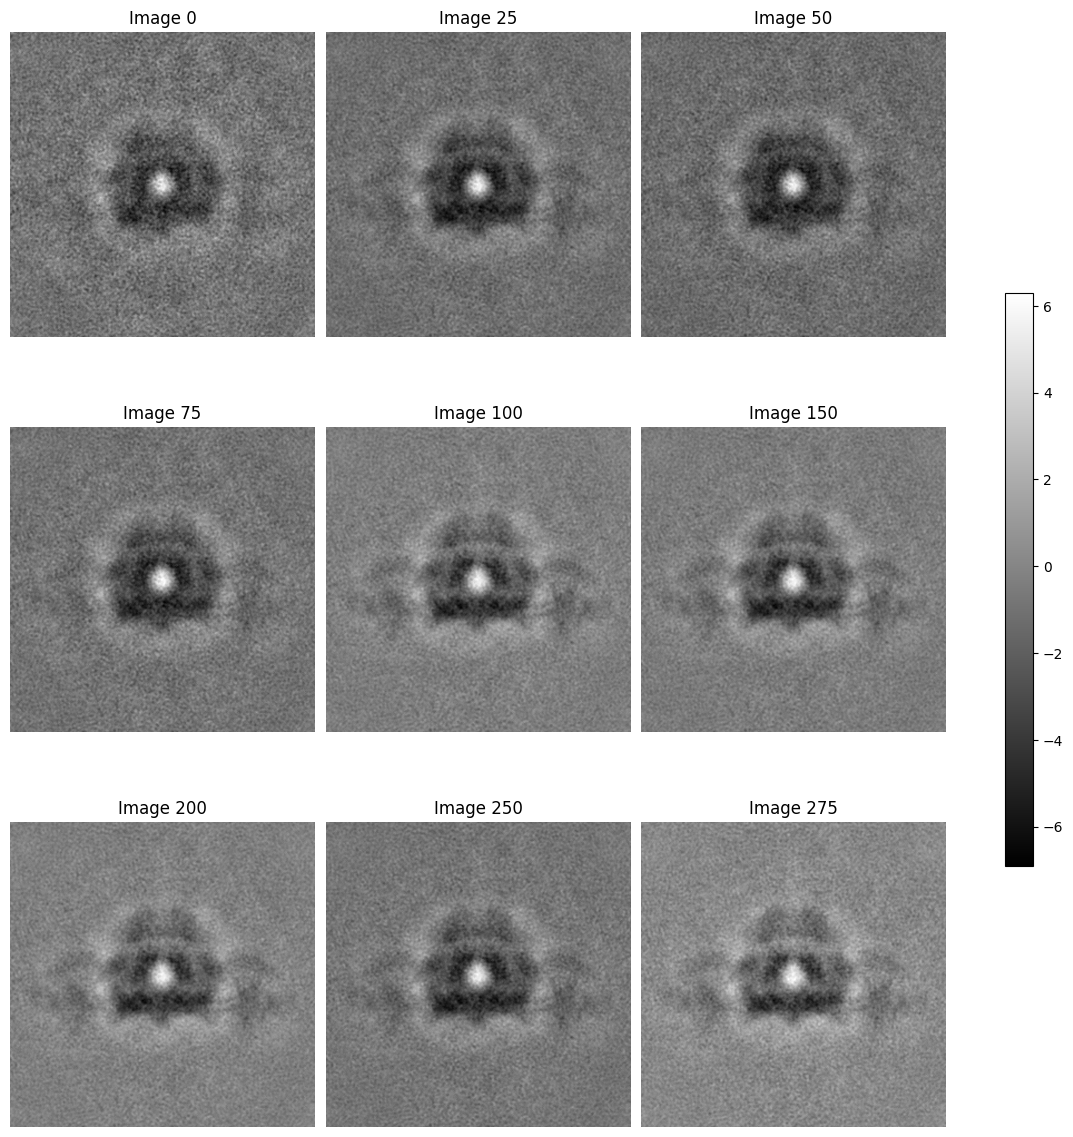

In [42]:
# Where 'dim' is the dimension of the images and let us an image index to visualize
image_indices = [0, 25, 50, 75, 100, 150, 200, 250, 275]  # indices
# Set up the subplot grid
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
# Flatten axes for easy iteration
axes_flat = axes.flatten()
# Loop through the selected image indices
for i, image_index in enumerate(image_indices):
    # Reshape the column from IMGT to its original 2D image shape
    image = IMGT[:, image_index].reshape(dim, dim)
    # Visualize the image
    ax = axes_flat[i]
    im = ax.imshow(image, cmap='gray')
    ax.set_title(f'Image {image_index}')
    ax.axis('off')  # Hide axes ticks
# Adjust layout to prevent overlap
plt.tight_layout()
# Add a colorbar
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)
plt.show()

#### 2. Analyzing Mean Topological Features (Topo_mean)

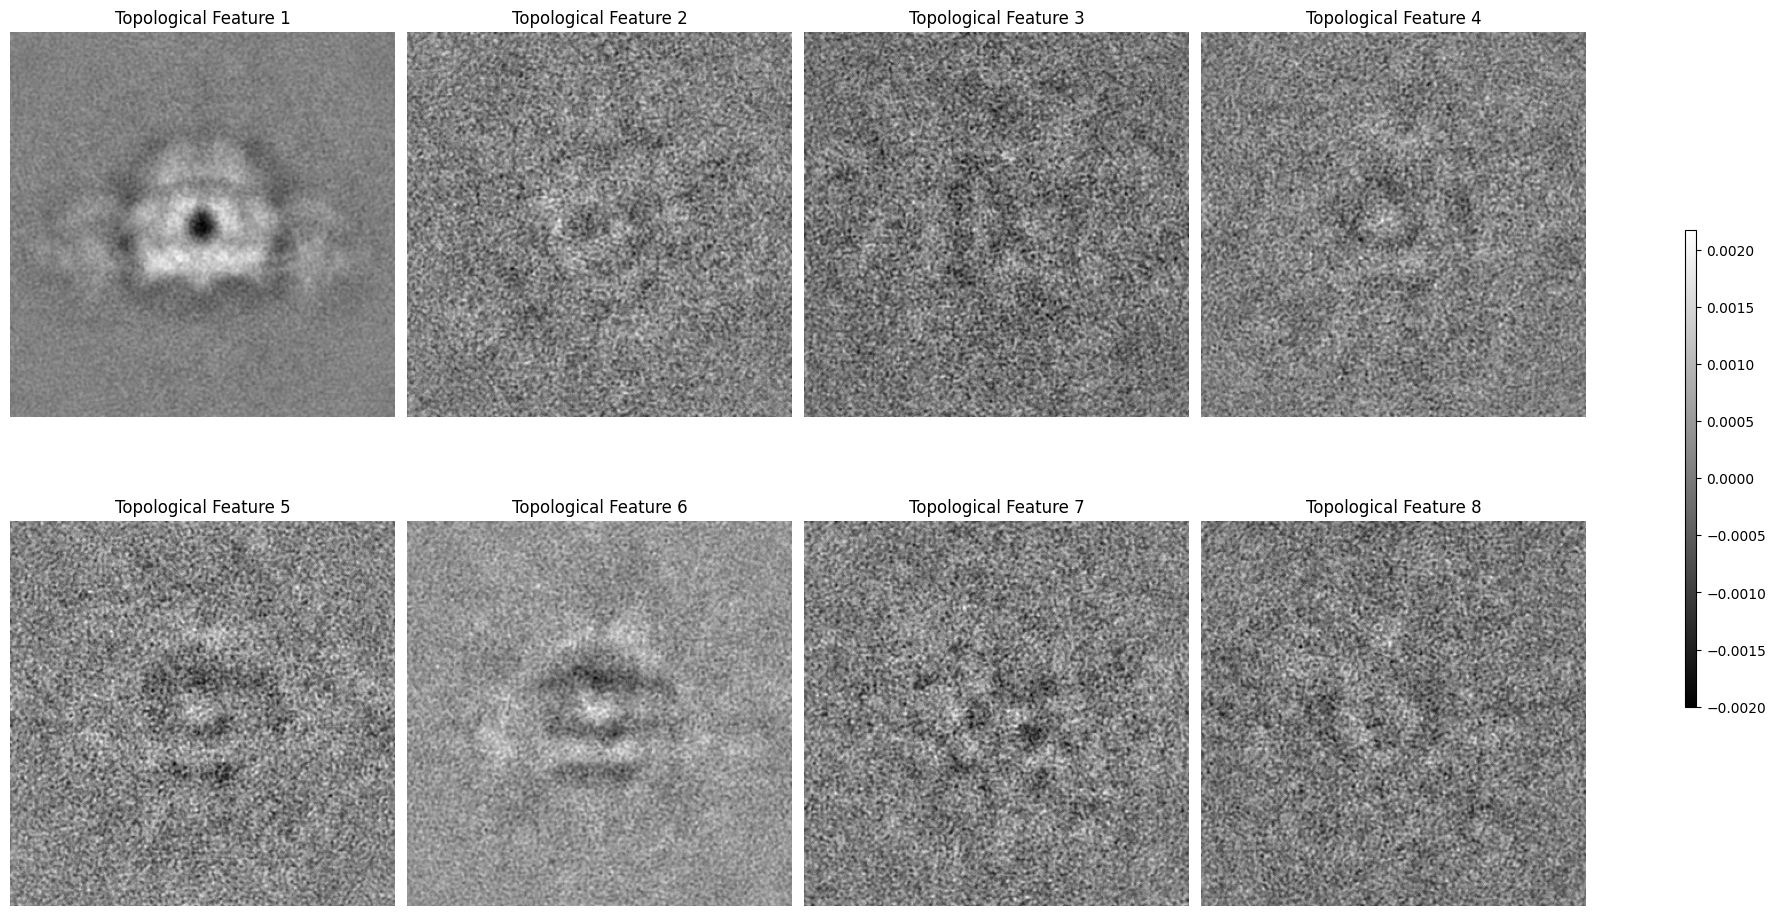

In [43]:
# Visualize the first topological features as an image
# Set up the subplot grid
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Adjust figsize as needed
# Loop through all 8 topological features
for i in range(8):
    # Select the current topological feature
    topo_feature = Topo_mean[:, i].reshape(dim, dim)
    # Determine the current subplot
    ax = axes[i // 4, i % 4]  # Integer division and modulo for row and column indices
    # Visualize the topological feature
    im = ax.imshow(topo_feature, cmap='gray')
    ax.set_title(f'Topological Feature {i+1}')
    ax.axis('off')  # Hide axes ticks
# Adjust layout to prevent overlap
plt.tight_layout()
# Add a colorbar
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5, aspect=40)
plt.show()

#### 3. Distribution of Temporal Parameters (tau)

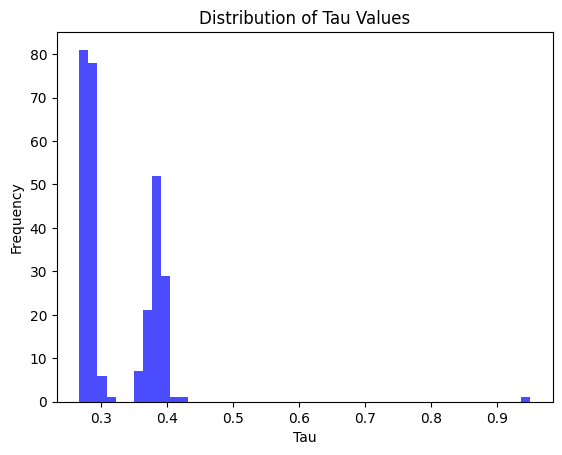

In [44]:
# Distribution of Temporal Parameters (tau)
plt.hist(tau, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Tau Values')
plt.xlabel('Tau')
plt.ylabel('Frequency')
plt.show()

#### 4. Eigenvector Visualization (psirec and psiC1)

Number of reconstructed eigenvectors (psirec): 15
Number of original eigenvectors (psiC1): 15


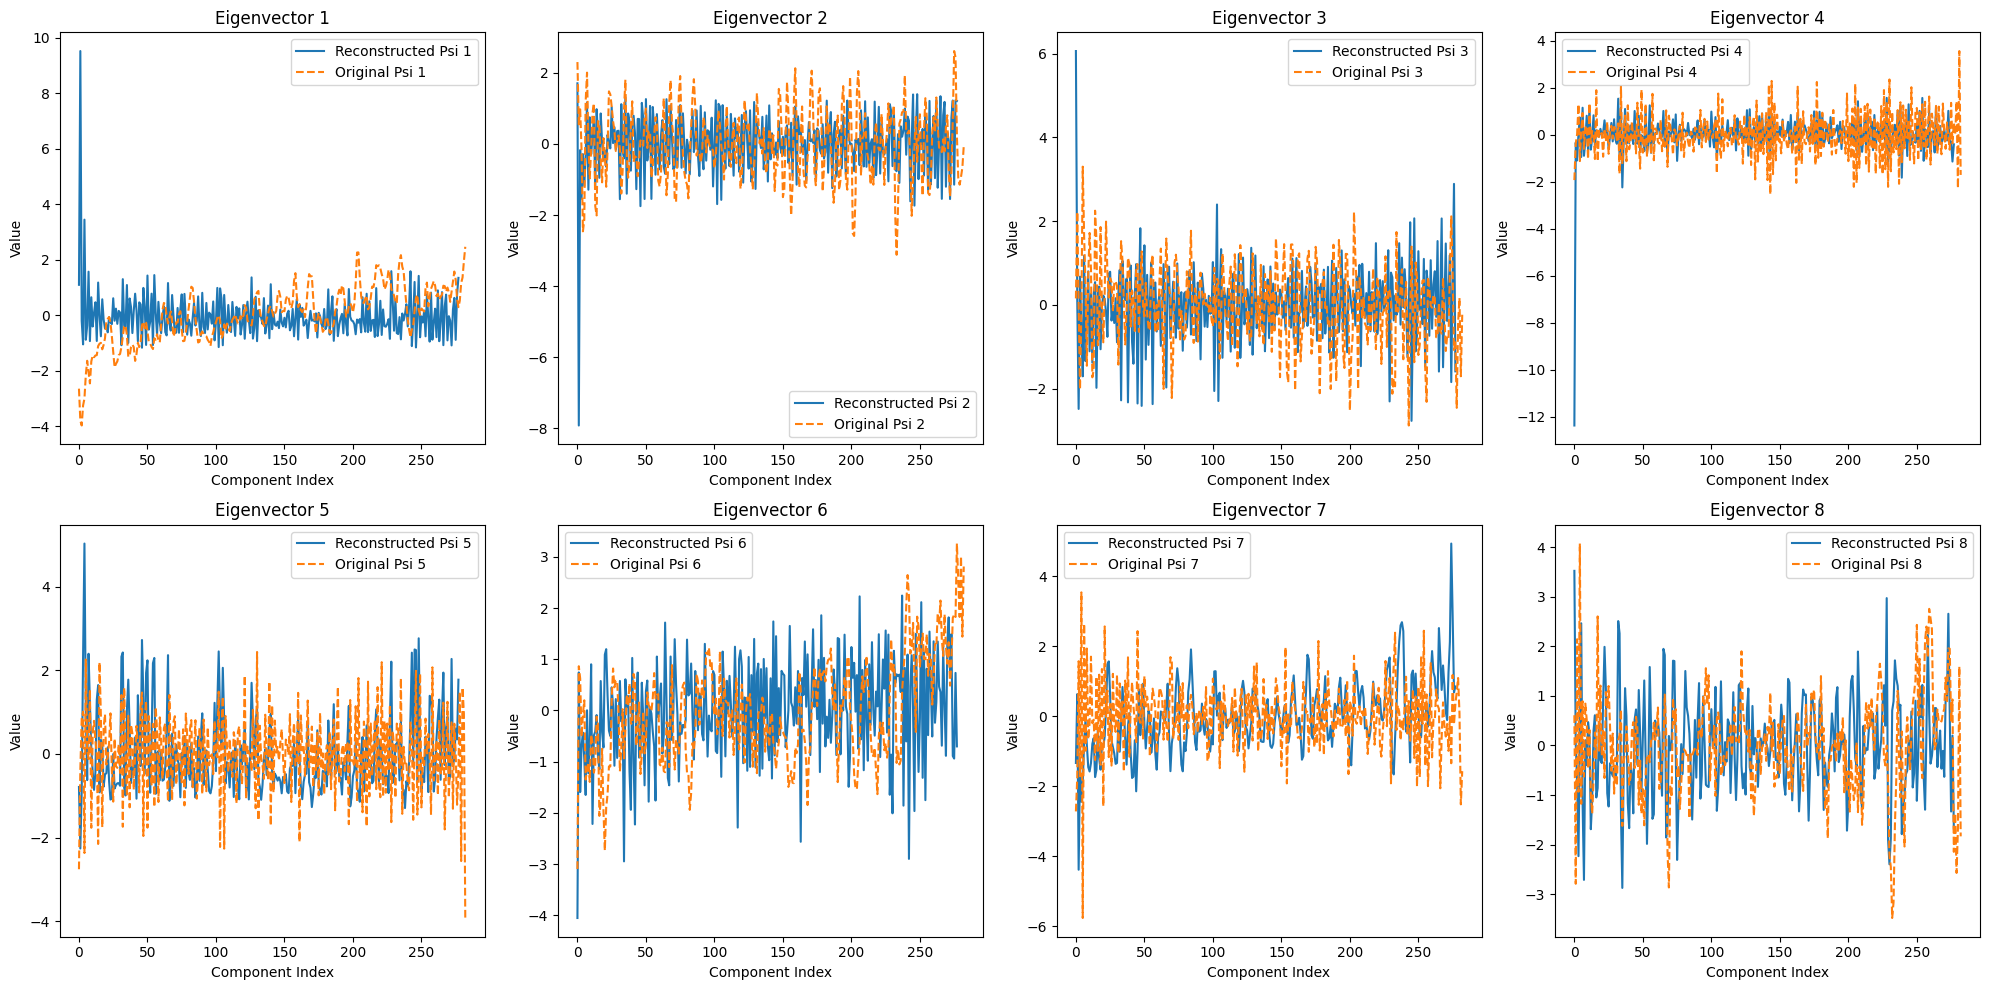

In [45]:
# Plotting the First 8 Eigenvectors in a 2x4 Grid
num_eigenvectors_psirec = psirec.shape[1]
num_eigenvectors_psiC1 = psiC1.shape[1]
print(f"Number of reconstructed eigenvectors (psirec): {num_eigenvectors_psirec}")
print(f"Number of original eigenvectors (psiC1): {num_eigenvectors_psiC1}")
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Adjust figsize as needed
for i in range(8):  # Plotting the first 8 eigenvectors
    ax = axes[i // 4, i % 4]  # Determine the current subplot for a 2x4 grid
    ax.plot(psirec[:, i], label=f'Reconstructed Psi {i+1}')
    ax.plot(psiC1[:, i], label=f'Original Psi {i+1}', linestyle='--')
    ax.set_title(f'Eigenvector {i+1}')
    ax.set_xlabel('Component Index')
    ax.set_ylabel('Value')
    ax.legend()

plt.tight_layout()
plt.show()

#### 5. Singular Values (sdiag)

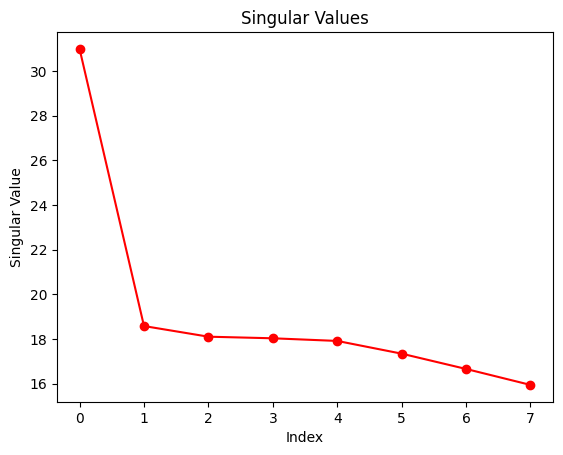

In [46]:
# Singular Values (sdiag)
plt.plot(sdiag, marker='o', linestyle='-', color='r')
plt.title('Singular Values')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.show()

## NLSA example

Let us consider a small, synthetic dataset for demonstration purposes. Imagine we have a dataset composed of points that lie on a nonlinear curve or manifold within a higher-dimensional space. Our goal is to use  Nonlinear Laplacian Spectral Analysis (NLSA) to uncover the underlying structure of this data. 

**Step 1: Constructing the Graph** 

**Data Representation** 

Suppose our dataset consists of points X = {x_1, x_2, ..., x_n} in a high-dimensional space.

**Graph Construction** 

We construct a graph where each point x_i is a node. Nodes are connected to their k nearest neighbors based on some distance metric (e.g., Euclidean distance).

**Step 2: Creating the Laplacian Matrix** 

**Weight Matrix** 

Create a weight matrix W, where W_ij represents the weight (or similarity) between points x_i and x_j. This could be an exponential function of their distance, for instance, W_ij = exp(-||x_i - x_j||^2 / t), where t is a scaling parameter. 

**Degree Matrix** 

Construct a diagonal degree matrix D, where each diagonal element D_ii is the sum of the weights of all edges connected to node i.

**Laplacian Matrix** 

The Laplacian matrix L is defined as L = D - W. 

**Step 3: Eigenvalue Decomposition** 

**Computing Eigenvalues and Eigenvectors** 

Perform eigenvalue decomposition on the Laplacian matrix L. This gives us a set of eigenvalues and their corresponding eigenvectors.

**Low-Dimensional Representation** 

Select the top k eigenvectors corresponding to the smallest non-zero eigenvalues. These eigenvectors provide a low-dimensional representation of our data. 

**Step 4: Analysis and Interpretation** 

**Interpreting the Eigenvectors** 

Each of the selected eigenvectors represents a dimension in the lower-dimensional space. Points that were close on the manifold in the high-dimensional space will be close in this new space.

**Visualization** 

If we choose two or three eigenvectors, we can visualize the data in 2D or 3D, revealing its intrinsic structure.


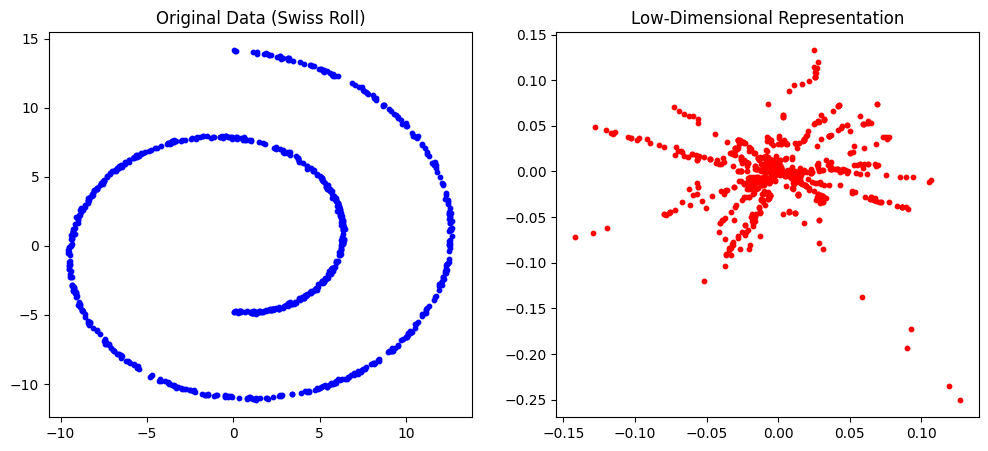

In [47]:
# Generate a synthetic 'Swiss Roll' dataset for demonstration
n_samples = 800
noise = 0.05
X, _ = make_swiss_roll(n_samples, noise=noise)
X = X[:, [0, 2]]  # Simplifying to 2D for easier visualization

# Construct the k-nearest neighbors graph
k = 10  # number of neighbors
A = kneighbors_graph(X, k, mode='connectivity', include_self=True)

# Create the Laplacian matrix
L = laplacian(A, normed=True)

# Compute the eigenvalues and eigenvectors for sparse matrix
# Since we are only interested in the smallest non-zero eigenvalues, 'which' parameter is set to 'SM'
# (which stands for smallest magnitude)
eigenvalues, eigenvectors = eigsh(L, k=k+1, which='SM')

# Low-dimensional representation
# We skip the first eigenvector (corresponding to the smallest eigenvalue which is zero)
low_dim_data = eigenvectors[:, 1:3]

# Visualizing the original and the transformed data
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Original Data
ax[0].scatter(X[:, 0], X[:, 1], c='blue', s=10)
ax[0].set_title('Original Data (Swiss Roll)')

# Transformed Data
ax[1].scatter(low_dim_data[:, 0], low_dim_data[:, 1], c='red', s=10)
ax[1].set_title('Low-Dimensional Representation')

plt.show()